In [62]:
import numpy as np
from astropy.io import fits
import warnings
from scipy import optimize
# import muse_tools as mt
import matplotlib.pyplot as plt
from astropy.stats import gaussian_sigma_to_fwhm


def gauss2D(amp, x0, y0, xsig, ysig):
    return lambda x, y: amp * np.exp(-(((x0 - x)/xsig)**2 +
                                       ((y0 - y)/ysig)**2)/2)

def moments(data):
    total = np.abs(data).sum()
    Y, X = np.indices(data.shape)
    y = np.argmax((X * np.abs(data)).sum(axis = 1) / total)
    x = np.argmax((Y * np.abs(data)).sum(axis = 0) /total)
    col = data[int(y), :]
    row = data[:, int(x)]
    xwidth = np.sqrt(np.abs((np.arange(col.size) - y)*col).sum() / 
                     np.abs(col).sum())
    ywidth = np.sqrt(np.abs((np.arange(row.size) - x)*row).sum() /
                     np.abs(row).sum())
    height = data.max()
    mom = np.array([ywidth, xwidth])
    return height, y, x, ywidth, xwidth

def fitgauss(data):
    params = (moments(data))
    errorfunction = lambda p: np.ravel(gauss2D(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, x0 = params)
    return p

In [60]:
f = fits.open('data/HD163296_SIIF_6730.fits')[0]
data = f.data
hdr = f.header

In [54]:
mnts = moments(data)

In [55]:
mnts

(3.8383192125710213e-16, 104, 84, 9.755932565246006, 7.148536029179898)

In [78]:
p = fitgauss(data[140:241, 60:101])
fit = gauss2D(*p)
Y, X = np.indices(data[140:241, 60:101].shape)

In [64]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


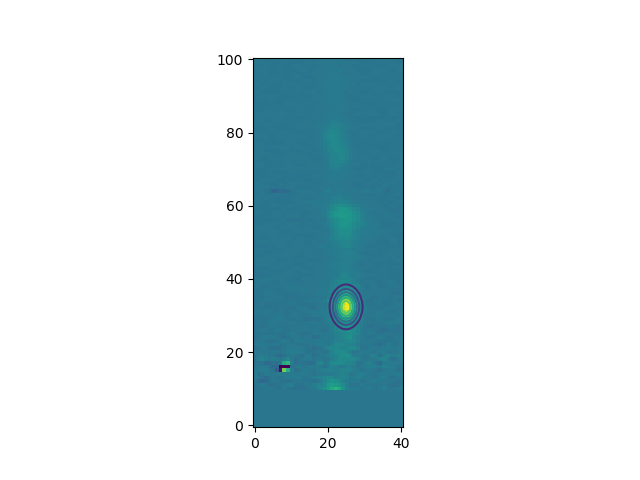

[3.52816464e-16 3.23795895e+01 2.49408304e+01 3.08250830e+00
 2.23585760e+00]


In [79]:
%matplotlib notebook

plt.imshow(data[140:241, 60:101], origin = 'lower')
plt.contour(fit(Y, X))
print(p)

In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
from telassar import PVSlice
import astropy.units as u

pv = PVSlice(filename = 'data/HD163296_SIIF_6730.fits')

In [269]:
pv2 = pv.spectral_window(vmin = -400, vmax = 400, unit = u.Unit('km/s'))
#test = pv.spectral_window(vmin = 200, vmax = 300, unit = u.Unit('km/s'))
import numpy as np
#pv2 = pv2.data * 1e16
#new_pv += np.abs(new_pv.min())
#new_pv.max()
pv2.min()
sig

0.00459083963158354

4.590839631583557e-19


<IPython.core.display.Javascript object>


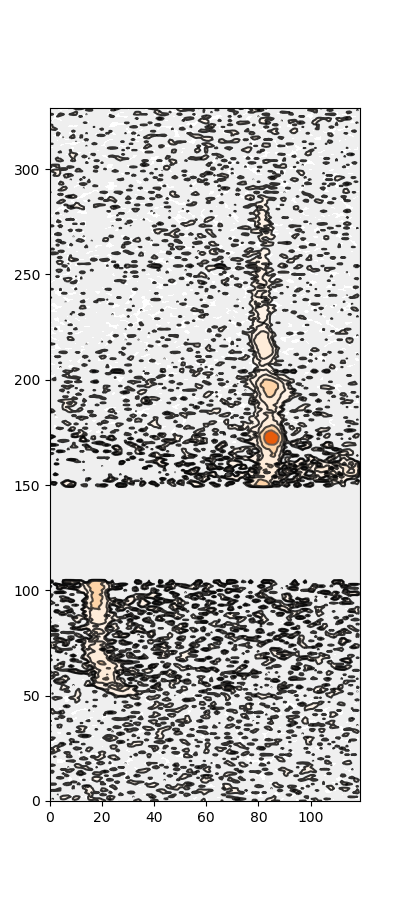

In [375]:
%matplotlib notebook
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats

sig = 3*sigma_clipped_stats(pv2.data, sigma = 4.5)[0]
print(sig)
lvls3 = np.array([sig, np.sqrt(2)*sig, 2*np.sqrt(2)*sig, 3*np.sqrt(2)*sig, 4*np.sqrt(2)*sig,
                 8*np.sqrt(2)*sig, 16*np.sqrt(2)*sig, 32*np.sqrt(2)*sig])
lvls1 = np.array([sig*2*np.sqrt(2)**(i) for i in range(3, 21, 3)])
lvls2 = np.linspace(np.log(np.abs(pv2.min())), 1*sig, 9)
#lvls3 = sig


fig, ax = plt.subplots(figsize = (4,9))
jet1 = ax.contour(pv2.data, levels = (lvls1), cmap = 'gist_gray', alpha = 0.8)
jet2 = ax.contourf(pv2.data, levels = (lvls1), cmap = 'Oranges', alpha = 1)
bkg = ax.contourf(pv2.data, levels = lvls2, cmap = 'gray', alpha = 1)

In [388]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma = 3.)
bkg_estimator = MedianBackground()
bkgrd = Background2D(pv2.data, (50, 50), filter_size = (3,3), 
                    sigma_clip = sigma_clip, bkg_estimator=bkg_estimator)

print(bkgrd.background_rms_median)
print(sig)

print(sig < bkgrd.background_rms_median)

2.953126982739461e-18
4.590839631583557e-19
True


<IPython.core.display.Javascript object>


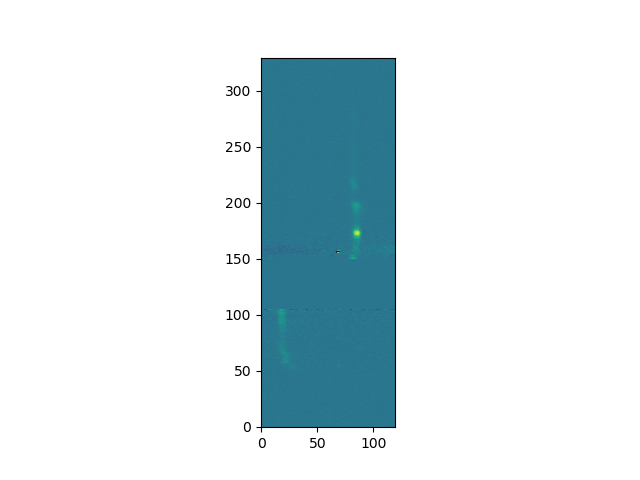

In [384]:
%matplotlib notebook

plt.imshow(bkgrd.background, origin = 'lower')
plt.imshow(pv2._data - bkgrd.background, origin = 'lower')

<IPython.core.display.Javascript object>


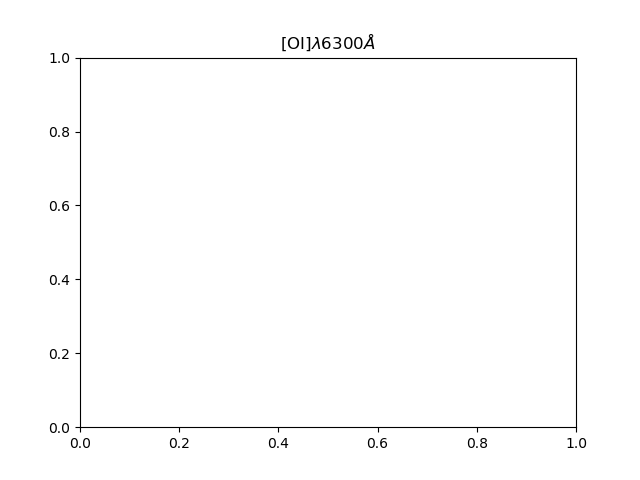

Text(0.5, 1.0, '$[\\mathrm{OI}]\\lambda 6300\\AA$')

In [172]:
lines = {
        'OI6300':   [6300.304, 'Angstrom', r'$[\mathrm{OI}]\lambda 6300\AA$'],
        'OI6363':   [6363.777, 'Angstrom', r'$[\mathrm{OI}]\lambda 6363\AA$'],
        'NII6548':  [6548.04, 'Angstrom', r'$[\mathrm{NII}]\lambda 6548\AA$'],
        'NII6583':  [6583.46,  'Angstrom', r'$[\mathrm{NII}]\lambda 6583\AA$'],
        'HAlpha':   [6562.8,  'Angstrom', r'$\mathrm{H}\alpha$'],
        'HBeta':    [4861.325,  'Angstrom', r'$\mathrm{H}\beta$'],
        'SII6716':  [6716.44,  'Angstrom', r'$[\mathrm{SII}]\lambda 6716\AA$'],
        'SII6731':  [6730.81,  'Angstrom', r'$[\mathrm{SII}]\lambda 6730\AA$'],
        'CaII7291': [7291.47, 'Angstrom', r'$[\mathrm{CaII}]\lambda 7291\AA$'],
        'CaII7324': [7323.89, 'Angstrom', r'$[\mathrm{CaII}]\lambda 7324\AA$']
}

emline = 'OI6300'

if emline in (lines.keys()):
    t = lines[emline][2]
    
fig = plt.figure()
plt.title(rf'{t}')